# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

np.random.seed(seed=42)

In [3]:
# df = pd.read_csv('Churn_Modelling.csv')
df = pd.read_csv('/datasets/Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Колонки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента

Заметим, что колонки `RowNumber`, `CustomerId` и `Surname` нам не понадобятся, удалим их.

In [4]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Пропусков в данных нет, столбцы с типом object закодируем с помощью техники OneHotEncoding, столбцы с типом float приведем к типу int, т.к. цифры после запятой нас не интересуют. 

In [6]:
print('Дубликаты:',df.duplicated().sum())

Дубликаты: 0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


Значения в разных столбцах различаются в сотни раз, проведем нормировку данных перед обучением моделей.

In [8]:
df = pd.get_dummies(df, drop_first=True)

In [9]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [10]:
df = df.astype('int')
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0,2,1,0,96270,0,0,0,1
9996,516,35,10,57369,1,1,1,101699,0,0,0,1
9997,709,36,7,0,1,0,1,42085,1,0,0,0
9998,772,42,3,75075,2,1,0,92888,1,1,0,1


# 2. Исследование задачи

In [11]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Из всей выборки только 20% клиентов ушли из банка.

Попробуем решить задачу не избавляясь от дизбаланса классов.

Изначально у нас нет тестовой части для нашей задачи, сделаем её, взяв 20% данных. Не будем выделять отдельно часть для валидации, а применим кроссвалидацию, реализованную в библиотеке skikit-learn. Количество фолдов оставим равным 5.

In [12]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Рассмотрим 4 модели:
- случайный лес;
- логистическую регрессию;
- метод ближайщих соседей;
- градиентный бустинг.

В каждой модели сделаем нормализацию входных данных,а затем проведем решетчатый поиск оптимальных параметров. Для этого используем конвейер, реализованный в библиотеке skikit-learn, - pipeline, он позволяет объединять различные классы предварительной обработки в одну цепочку, а так же решает проблему просачивания информации из валидационной выборки на кроссвалидации при предварительной нормализации данных. 

Затем объединим все модели с помощью стэкинга* и посмотрим, что получится.

*Стэкинг позволяет использовать преимущества и сглаживать недостатки разных моделей. Используем все предыдущие модели с найденными оптимальными параметрами, в качестве итогового классификатора используем простую логистическую регрессию.

In [13]:
def fit_models(X_train, y_train, class_weight=None, scoring=['f1','roc_auc'], refit='f1', sampler=None):
    
    # Случайный лес
    print('Random forest')
    time_start_1 = time.time()
    if sampler:
        pipe = make_pipeline(MinMaxScaler(), sampler, RandomForestClassifier(random_state=42, class_weight=class_weight)) 
    else:
        pipe = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=42, class_weight=class_weight)) 
    params = { 
        'randomforestclassifier__n_estimators': [100, 200, 500, 800, 1000],
        'randomforestclassifier__max_depth' : [4,5,6,7,8,10,15,20]
    }
    gridsearch_1 = GridSearchCV(pipe, params, cv=5, n_jobs=-1, verbose=2, scoring=scoring, refit=refit)
    gridsearch_1.fit(X_train, y_train)
    results = gridsearch_1.cv_results_
    f1_score_1 = gridsearch_1.best_score_
    roc_auc_score_1 = results['mean_test_roc_auc'][results['rank_test_f1']==1][0]
    time_1 = int(time.time()-time_start_1)
    print(time_1//60, 'min', time_1%60, 'sec')
    print('Best parameters:', gridsearch_1.best_params_)
    print(f'Best F1 score: {f1_score_1:.4}')
    print(f'Roc-auc score: {roc_auc_score_1:.4}')
    print()
    
    
    # Логистическая регрессия
    print('Logistic regression')
    time_start_2 = time.time()
    if sampler:
        pipe = make_pipeline(MinMaxScaler(), sampler, LogisticRegression(random_state=42, class_weight=class_weight)) 
    else:
        pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42, class_weight=class_weight))
    params = { 
        'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logisticregression__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
        'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    gridsearch_2 = GridSearchCV(pipe, params, cv=5, n_jobs=-1, verbose=1, scoring=scoring, refit=refit)
    gridsearch_2.fit(X_train, y_train)
    results = gridsearch_2.cv_results_
    f1_score_2 = gridsearch_2.best_score_
    roc_auc_score_2 = results['mean_test_roc_auc'][results['rank_test_f1']==1][0]
    time_2 = int(time.time()-time_start_2)
    print(time_2//60, 'min', time_2%60, 'sec')
    print('Best parameters:', gridsearch_2.best_params_)
    print(f'Best F1 score: {f1_score_2:.4}')
    print(f'Roc-auc score: {roc_auc_score_2:.4}')
    print()
    
    
    # Метод ближайших соседей
    print('K neighbors')
    time_start_3 = time.time()
    if sampler:
        pipe = make_pipeline(MinMaxScaler(), sampler, KNeighborsClassifier()) 
    else:
        pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
    params = { 
        'kneighborsclassifier__n_neighbors': list(range(20)),
        'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    gridsearch_3 = GridSearchCV(pipe, params, cv=5, n_jobs=-1, verbose=1, scoring=scoring, refit=refit)
    gridsearch_3.fit(X_train, y_train)
    results = gridsearch_3.cv_results_
    f1_score_3 = gridsearch_3.best_score_
    roc_auc_score_3 = results['mean_test_roc_auc'][results['rank_test_f1']==1][0]
    time_3 = int(time.time()-time_start_3)
    print(time_3//60, 'min', time_3%60, 'sec')
    print('Best parameters:', gridsearch_3.best_params_)
    print(f'Best F1 score: {f1_score_3:.4}')
    print(f'Roc-auc score: {roc_auc_score_3:.4}')
    print()
    
    
    # Градиентный бустинг
    print('Gradient Boosting')
    time_start_4 = time.time()
    if sampler:
        pipe = make_pipeline(MinMaxScaler(), sampler, GradientBoostingClassifier(random_state=42)) 
    else:
        pipe = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=42))
    params = { 
        'gradientboostingclassifier__n_estimators': [50, 100, 150, 200],
        'gradientboostingclassifier__min_samples_split': [2, 4, 8],
        'gradientboostingclassifier__min_samples_leaf': [1, 2, 4],
        'gradientboostingclassifier__max_depth': [1, 2, 3, 4, 5]
    }
    gridsearch_4 = GridSearchCV(pipe, params, cv=5, n_jobs=-1, verbose=1, scoring=scoring, refit=refit)
    gridsearch_4.fit(X_train, y_train)
    results = gridsearch_4.cv_results_
    f1_score_4 = gridsearch_4.best_score_
    roc_auc_score_4 = results['mean_test_roc_auc'][results['rank_test_f1']==1][0]
    time_4 = int(time.time()-time_start_4)
    print(time_4//60, 'min', time_4%60, 'sec')
    print('Best parameters:', gridsearch_4.best_params_)
    print(f'Best F1 score: {f1_score_4:.4}')
    print(f'Roc-auc score: {roc_auc_score_4:.4}')
    print()
    
    
    # Стэкинг
    print('Stacking')
    time_start_5 = time.time()
    estimators = [
        ('randomforestclassifier', gridsearch_1.best_estimator_[-1]),
        ('logisticregression', gridsearch_2.best_estimator_[-1]),
        ('kneighborsclassifier', gridsearch_3.best_estimator_[-1]),
        ('gradientboostingclassifier', gridsearch_4.best_estimator_[-1])
        ]
    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, class_weight=class_weight))
    if sampler:
        pipe = make_pipeline(MinMaxScaler(), sampler, clf) 
    else:
        pipe = make_pipeline(MinMaxScaler(), clf)
    pipe.fit(X_train, y_train)
    scores = cross_validate(pipe, X_train, y_train, scoring=['roc_auc', 'f1'], n_jobs=-1)
    f1_score_5 = scores['test_f1'].mean()
    roc_auc_score_5 = scores['test_roc_auc'].mean()
    time_5 = int(time.time()-time_start_5)
    print(time_5//60, 'min', time_5%60, 'sec')
    print(f'F1 score: {f1_score_5:.4}')
    print(f'Roc-auc score: {roc_auc_score_5:.4}')
    print()
    time_sum = time_1 + time_2 + time_3 + time_4 + time_5
    print('Total time:', time_sum//60, 'min', time_sum%60, 'sec')
    
    models = [
        (gridsearch_1.best_estimator_, f1_score_1, roc_auc_score_1, time_1, 'Random forest'),
        (gridsearch_2.best_estimator_, f1_score_2, roc_auc_score_2, time_2, 'Logistic regression'),
        (gridsearch_3.best_estimator_, f1_score_3, roc_auc_score_3, time_3, 'K neighbors'),
        (gridsearch_4.best_estimator_, f1_score_4, roc_auc_score_4, time_4, 'Gradient Boosting'),
        (pipe, f1_score_5, roc_auc_score_5, time_5, 'Stacking')
        ]
    
    return models
    

In [14]:
models_1 = fit_models(X_train, y_train)

Random forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
2 min 20 sec
Best parameters: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 500}
Best F1 score: 0.5888
Roc-auc score: 0.8563

Logistic regression
Fitting 5 folds for each of 140 candidates, totalling 700 fits
0 min 4 sec
Best parameters: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'none', 'logisticregression__solver': 'newton-cg'}
Best F1 score: 0.3209
Roc-auc score: 0.7619

K neighbors
Fitting 5 folds for each of 80 candidates, totalling 400 fits
0 min 40 sec
Best parameters: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 1}
Best F1 score: 0.4339
Roc-auc score: 0.6429

Gradient Boosting
Fitting 5 folds for each of 180 candidates, totalling 900 fits
3 min 6 sec
Best parameters: {'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2,

Лучший результат показал градиентный бустинг, его результат f1 - 0.5925, что уже проходит минимальный порог. Лучшая метрика roc-auc у стэкинга - 0.8633.

# 3. Борьба с дисбалансом

Наши классы представлены не одинаково, а в пропорции 1:4. В борьбе с дисбалансом попробуем несколько методов.

Для начала используем балансировку классов, заложенную в некоторых использованных моделях с пометкой class_weight.

Затем попробуем увеличить и уменьшить выборки с помощью RandomUnderSampler и RandomOverSampler библиотеки imbalanced-learn, для использования сэмлеров в цепочке pipeline в библиотеке реализована своя функция make_pipeline, которая работает с моделями sсikit-learn.

### Баланс классов коэффинциентами

In [15]:
models_2 = fit_models(X_train, y_train, class_weight='balanced')

Random forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
2 min 20 sec
Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 1000}
Best F1 score: 0.6251
Roc-auc score: 0.8612

Logistic regression
Fitting 5 folds for each of 140 candidates, totalling 700 fits
0 min 4 sec
Best parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best F1 score: 0.4944
Roc-auc score: 0.7649

K neighbors
Fitting 5 folds for each of 80 candidates, totalling 400 fits
0 min 40 sec
Best parameters: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 1}
Best F1 score: 0.4339
Roc-auc score: 0.6429

Gradient Boosting
Fitting 5 folds for each of 180 candidates, totalling 900 fits
3 min 8 sec
Best parameters: {'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gra

Получилось улучшить результат, у случайного леса f1 - 0.6251, у стэкинга roc-auc - 0.8644.

### Увеличение выборки

In [16]:
ros = RandomOverSampler(random_state=42)
models_3 = fit_models(X_train, y_train, sampler=ros)

Random forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
2 min 58 sec
Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 200}
Best F1 score: 0.6151
Roc-auc score: 0.8611

Logistic regression
Fitting 5 folds for each of 140 candidates, totalling 700 fits
0 min 6 sec
Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Best F1 score: 0.4921
Roc-auc score: 0.7645

K neighbors
Fitting 5 folds for each of 80 candidates, totalling 400 fits
1 min 1 sec
Best parameters: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 18}
Best F1 score: 0.4992
Roc-auc score: 0.7661

Gradient Boosting
Fitting 5 folds for each of 180 candidates, totalling 900 fits
4 min 58 sec
Best parameters: {'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__min_samples_split': 8, 'gradie

Лучшие f1 и roc-auc - у случайного леса, 0.6151 и 0.8611 соответственно.

In [17]:
rus = RandomUnderSampler(random_state=42)
models_4 = fit_models(X_train, y_train, sampler=rus)

Random forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
1 min 14 sec
Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 200}
Best F1 score: 0.5911
Roc-auc score: 0.8561

Logistic regression
Fitting 5 folds for each of 140 candidates, totalling 700 fits
0 min 2 sec
Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Best F1 score: 0.4982
Roc-auc score: 0.765

K neighbors
Fitting 5 folds for each of 80 candidates, totalling 400 fits
0 min 19 sec
Best parameters: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 5}
Best F1 score: 0.4832
Roc-auc score: 0.7453

Gradient Boosting
Fitting 5 folds for each of 180 candidates, totalling 900 fits
1 min 25 sec
Best parameters: {'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_leaf': 4, 'gradientboostingclassifier__min_samples_split': 2, 'gradien

Лучший результат при уменьшении выборки: f1 - градиентный бустинг, 0.5961, roc-auc - стэкинг, 0.8609.

In [18]:
def plot_results(name, n):
    models_results = pd.DataFrame([row[4] for row in models_1], columns=['model'])
    models_results[f'{name}1'] = [row[n] for row in models_1]
    models_results[f'{name}2'] = [row[n] for row in models_2]
    models_results[f'{name}3'] = [row[n] for row in models_3]
    models_results[f'{name}4'] = [row[n] for row in models_4]
    res = pd.DataFrame(models_results.T[1:])
    res.columns=models_results['model']
    res.index = ['Ordinary', 'Balanced', 'Upsampled', 'Undersampled']
    res.plot()
    plt.title(name)

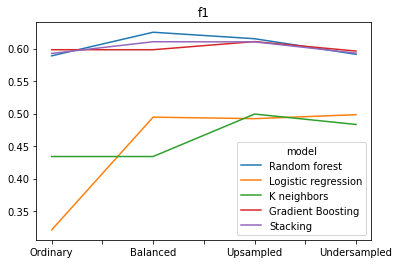

In [19]:
plot_results('f1', 1)

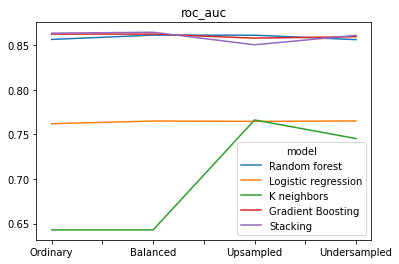

In [20]:
plot_results('roc_auc',2)

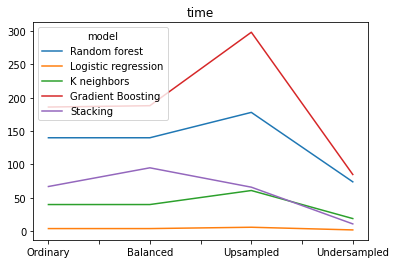

In [21]:
plot_results('time',3)

После проведенного исследования в качестве финальной модели выбираем RandomForestClassifier с внутренней балансировкой классов, его f1 - 0.6251.

Лучшее качество на roc-auc показала модель стэкинга с внутренной балансировкой классов - 0.8644.

Заметим, что модели стэкинга, случайного леса и градиентного бустинга, в целом дают очень близкий результат, возможно, при более тщательном подборе гиперпараметров распределившиемя места поменяются. 

# 4. Тестирование модели

In [22]:
final_model = models_2[0][0]
final_model

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=1000, random_state=42))])

In [23]:
f1 = f1_score(y_test, final_model.predict(X_test))
roc_auc = roc_auc_score(y_test, final_model.predict(X_test))
print(f"Test f1 score: {f1:.4}")
print(f"Test roc-auc score: {roc_auc:.4}")

Test f1 score: 0.626
Test roc-auc score: 0.7767


На финальном тестировании наша модель получила: f1 - 0.626, что больше порога 0.59, и roc-auc - 0.7767, что ниже, чем у большинства моделей на валидации.

#  Вывод

В ходе работы мы:

- подготовили данные для обучения: убрали лишние признаки, провели кодирование признаков и приведение к нужным типам, разделили данные на тестовую и тренировочную выборки;
- провели поиск оптимальной модели в ограниченном пространстве гипермараметров в разных случаях:
  - не изменяя баланс классов;
  - используя встроенную банасировку;
  - увеличив выборку;
  - уменьшив выборку.
- провели оценку лучшей модели на тестовых данных.

Лучший метод борьбы с дисбалансом - встроенная балансировка классов.

Лучшая модель: пайплайн состоящий из нормализатора MinMaxScaler и классификатора RandomForestClassifier c параметрами: class_weight='balanced', max_depth=10, n_estimators=1000, random_state=42. Полученная метрика на тестовой выборке f1 - 0.626

Возможности для увеличения точности модели: 
- расширение пространства поиска оптимальных гиперпараметров;
- применение других классификаторов, например, градиентных бустингов lightgbm, xgboost, catboost или классификаторов на основе нейронных сетей.